<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [140]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [141]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier
# Model Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

This function is to plot the confusion matrix.


In [142]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [143]:
from js import fetch
import io

URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [144]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [145]:
data.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Class
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6104.959412,1.788889,3.500000,1.655556,-86.366477,29.449963,0.666667
std,26.124701,4694.671720,1.213172,1.595288,1.710254,14.149518,2.141306,0.474045
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,-80.603956,28.561857,0.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,-80.577366,28.561857,1.000000
75%,67.750000,8912.750000,2.000000,5.000000,3.000000,-80.577366,28.608058,1.000000
max,90.000000,15600.000000,6.000000,5.000000,5.000000,-80.577366,34.632093,1.000000


In [146]:
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [147]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [148]:
X.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,...,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6104.959412,1.788889,3.500000,1.655556,0.011111,0.011111,0.300000,0.011111,0.233333,...,0.033333,0.044444,0.033333,0.011111,0.222222,0.777778,0.588889,0.411111,0.211111,0.788889
std,26.124701,4694.671720,1.213172,1.595288,1.710254,0.105409,0.105409,0.460825,0.105409,0.425322,...,0.180511,0.207235,0.180511,0.105409,0.418069,0.418069,0.494792,0.494792,0.410383,0.410383
min,1.000000,350.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,67.750000,8912.750000,2.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,90.000000,15600.000000,6.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [149]:
Y = data['Class'].to_numpy()
Y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [150]:
# students get this 
X = preprocessing.StandardScaler().fit(X).transform(X)
X


array([[-1.71291154e+00, -1.94814463e-16, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.67441914e+00, -1.19523159e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       [-1.63592675e+00, -1.16267307e+00, -6.53912840e-01, ...,
        -8.35531692e-01,  1.93309133e+00, -1.93309133e+00],
       ...,
       [ 1.63592675e+00,  1.99100483e+00,  3.49060516e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.67441914e+00,  1.99100483e+00,  1.00389436e+00, ...,
         1.19684269e+00, -5.17306132e-01,  5.17306132e-01],
       [ 1.71291154e+00, -5.19213966e-01, -6.53912840e-01, ...,
        -8.35531692e-01, -5.17306132e-01,  5.17306132e-01]])

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [151]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 2)

we can see we only have 18 test samples.


In [152]:
Y_test.shape

(18,)

In [153]:
Y_train.shape

(72,)

In [154]:
X_test.shape

(18, 83)

In [155]:
X_train.shape

(72, 83)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [156]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [157]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
logreg_cv = GridSearchCV(lr, parameters, cv = 10)

logreg_cv.fit(X_train,Y_train)



GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [158]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [159]:
lm_acc = logreg_cv.best_estimator_.score(X_test, Y_test)
lm_acc

0.8333333333333334

Lets look at the confusion matrix:


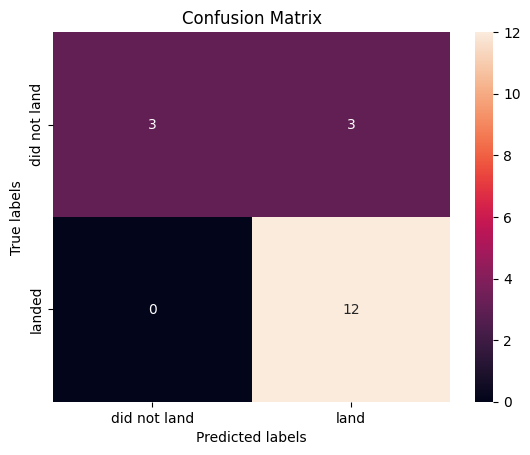

In [160]:
lm_yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,lm_yhat)

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


Evaluation Metrics for LR:

In [161]:
lm_prob = logreg_cv.predict_proba(X_test)[:,1]
lm_auc = roc_auc_score(Y_test, lm_prob)
lm_f1 = f1_score(Y_test, lm_yhat)
lm_prec = precision_score(Y_test, lm_yhat)
lm_rec = recall_score(Y_test, lm_yhat)

print("LM AUC: ", lm_auc)
print("LM F1 Score: ", lm_f1)
print("LM Accuracy: ", lm_acc)
print("LM Recall: ", lm_rec)
print("LM Precision: ", lm_prec)

LM AUC:  0.888888888888889
LM F1 Score:  0.888888888888889
LM Accuracy:  0.8333333333333334
LM Recall:  1.0
LM Precision:  0.8


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv - 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [162]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC(probability = True)

In [163]:
svm_cv = GridSearchCV(svm, parameters, cv=10)

svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=SVC(probability=True),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [164]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [165]:
svm_acc = svm_cv.best_estimator_.score(X_test, Y_test)
svm_acc

0.8333333333333334

We can plot the confusion matrix


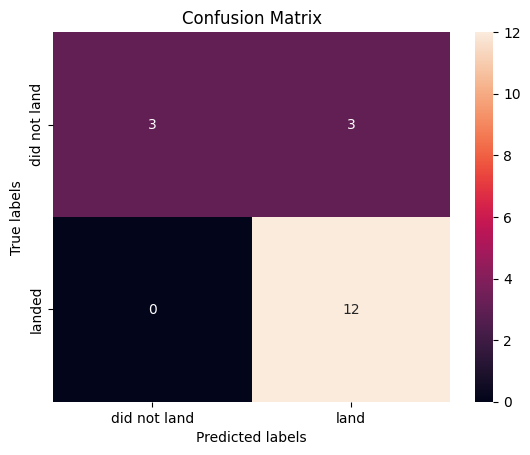

In [166]:
svm_yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,svm_yhat)

Model Evaluation Metrics for SVM:

In [167]:
svm_prob = svm_cv.predict_proba(X_test)[:,1]
svm_auc = roc_auc_score(Y_test, svm_prob)
svm_f1 = f1_score(Y_test, svm_yhat)
svm_prec = precision_score(Y_test, svm_yhat)
svm_rec = recall_score(Y_test, svm_yhat)

print("svm AUC: ", svm_auc)
print("svm F1 Score: ", svm_f1)
print("svm Accuracy: ", svm_acc)
print("svm Recall: ", svm_rec)
print("svm Precision: ", svm_prec)

svm AUC:  0.9583333333333334
svm F1 Score:  0.888888888888889
svm Accuracy:  0.8333333333333334
svm Recall:  1.0
svm Precision:  0.8


## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [168]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [169]:
tree_cv = GridSearchCV(tree, parameters, cv = 10)

In [172]:
tree_cv.fit(X_train,Y_train)

/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: 

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [174]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'random'}
accuracy : 0.875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [175]:
tree_acc = tree_cv.best_estimator_.score(X_test, Y_test)
tree_acc

0.7777777777777778

We can plot the confusion matrix


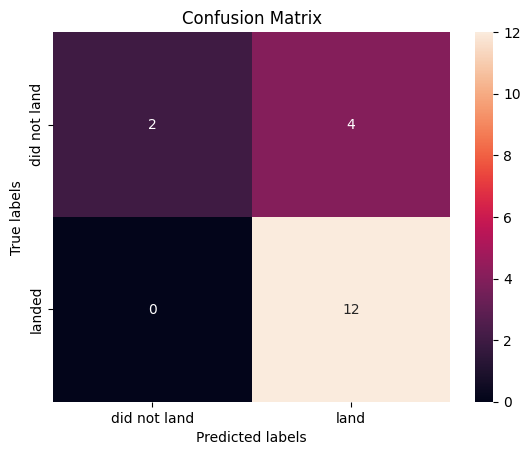

In [176]:
tree_yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,tree_yhat)

Model Evaluation Metrics for DecisionTree:

In [177]:
tree_prob = tree_cv.predict_proba(X_test)[:,1]
tree_auc = roc_auc_score(Y_test, tree_prob)
tree_f1 = f1_score(Y_test, tree_yhat)
tree_prec = precision_score(Y_test, tree_yhat)
tree_rec = recall_score(Y_test, tree_yhat)

print("tree AUC: ", tree_auc)
print("tree F1 Score: ", tree_f1)
print("tree Accuracy: ", tree_acc)
print("treeRecall: ", tree_rec)
print("treePrecision: ", tree_prec)

tree AUC:  0.6805555555555556
tree F1 Score:  0.8571428571428571
tree Accuracy:  0.7777777777777778
treeRecall:  1.0
treePrecision:  0.75


## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [178]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [179]:
knn_cv = GridSearchCV(KNN, parameters, cv = 10)

In [180]:
knn_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [181]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [182]:
knn_acc = knn_cv.best_estimator_.score(X_test, Y_test)
knn_acc

0.8333333333333334

We can plot the confusion matrix


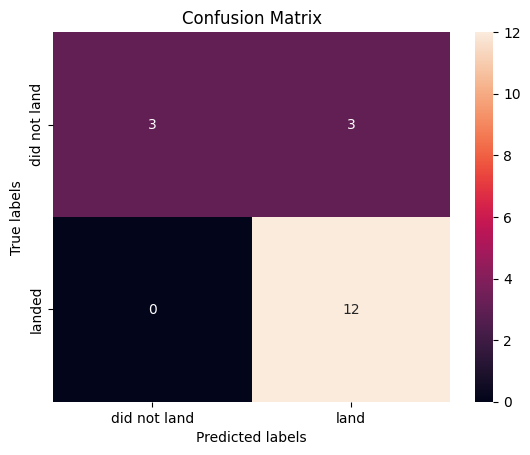

In [183]:
knn_yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,knn_yhat)

Model Evaluation Metrics for KNN:

In [184]:
knn_prob = knn_cv.predict_proba(X_test)[:,1]
knn_auc = roc_auc_score(Y_test, knn_prob)
knn_f1 = f1_score(Y_test, knn_yhat)
knn_prec = precision_score(Y_test, knn_yhat)
knn_rec = recall_score(Y_test, knn_yhat)

print("knn AUC: ", knn_auc)
print("knn F1 Score: ", knn_f1)
print("knn Accuracy: ", knn_acc)
print("knn Recall: ", knn_rec)
print("knn Precision: ", knn_prec)

knn AUC:  0.8958333333333334
knn F1 Score:  0.888888888888889
knn Accuracy:  0.8333333333333334
knn Recall:  1.0
knn Precision:  0.8


## TASK  12


Find the method performs best:


In [185]:
data = {'AUC': [lm_auc, svm_auc, tree_auc, knn_auc], 
        'F1': [lm_f1, svm_f1, tree_f1, knn_f1], 
        'Accuracy': [lm_acc, svm_acc, tree_acc, knn_acc], 
        'Recall': [lm_rec, svm_rec, tree_rec, knn_rec],
        'Precision': [lm_prec, svm_prec, tree_prec, knn_prec]}
df_data = pd.DataFrame(data, index = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN']).sort_values(by=['AUC'], ascending = False)
df_data

,AUC,F1,Accuracy,Recall,Precision
SVM,0.958333,0.888889,0.833333,1.0,0.80
KNN,0.895833,0.888889,0.833333,1.0,0.80
Logistic Regression,0.888889,0.888889,0.833333,1.0,0.80
Decision Tree,0.680556,0.857143,0.777778,1.0,0.75


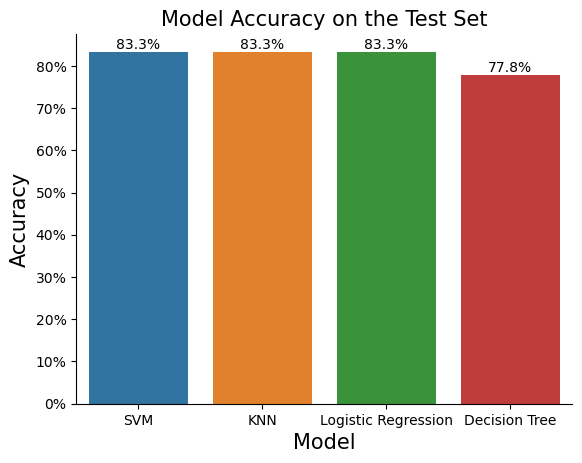

In [195]:
ax = sns.barplot(data = df_data, x = df_data.index, y = 'Accuracy')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Model Accuracy on the Test Set', fontsize=15)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color= 'black')

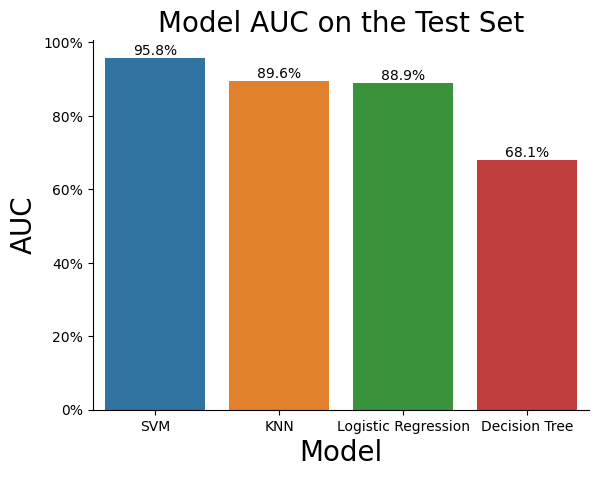

In [193]:
ax = sns.barplot(data = df_data, x = df_data.index, y = 'AUC')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel('Model', fontsize=20)
plt.ylabel('AUC', fontsize=20)
plt.title('Model AUC on the Test Set', fontsize=20)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x*100)))
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(p.get_height()*100), (p.get_x()+0.4, p.get_height()), 
                ha='center', va='bottom',color= 'black')

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
